In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

dagnelies_deepfake_faces_path = kagglehub.dataset_download('dagnelies/deepfake-faces')
xhlulu_140k_real_and_fake_faces_path = kagglehub.dataset_download('xhlulu/140k-real-and-fake-faces')
sokhnaballytour_test_progan_path = kagglehub.dataset_download('sokhnaballytour/test-progan')
sokhnaballytour_val_dataset_path = kagglehub.dataset_download('sokhnaballytour/val-dataset')
sokhnaballytour_train_dataset_path = kagglehub.dataset_download('sokhnaballytour/train-dataset')

print('Data source import complete.')


# Librairies import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import math
from torchmetrics import CohenKappa
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    matthews_corrcoef,
    f1_score,
    confusion_matrix,
    cohen_kappa_score,
    log_loss,
    recall_score,
    precision_score,
)


# Loading data with data augmentation

In [ ]:
# Définir les transformations avec data augmentation pour l'entraînement
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Removed p parameter
    transforms.GaussianBlur(kernel_size=3),  # Using GaussianBlur from torchvision
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Définir les transformations pour la validation et le test (sans data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionner les images
    transforms.ToTensor(),  # Convertir en tenseur
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normaliser
])


# Charger les datasets avec les transformations appropriées
train_dataset = ImageFolder(root="/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train", transform=train_transform)
valid_dataset = ImageFolder(root="/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid", transform=test_transform)
test_dataset = ImageFolder(root="/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test", transform=test_transform)

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

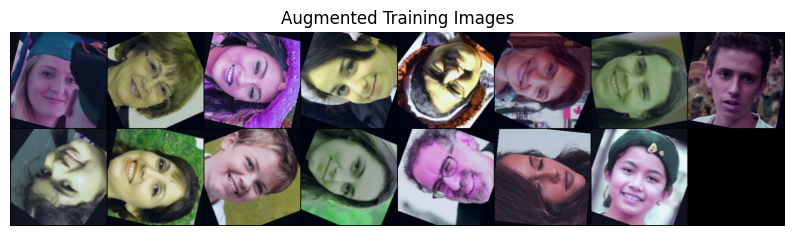

In [ ]:
# Récupérer un batch d'images
images, labels = next(iter(train_loader))

# Afficher les images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Augmented Training Images")
plt.imshow(
    np.transpose(vutils.make_grid(images[:15], padding=2, normalize=True).cpu(), (1, 2, 0))
)
plt.show()

# Optimized ViT with Latent Attention

In [ ]:
class LatentAttention(nn.Module):
    def __init__(self, dim, num_latents=128):
        super().__init__()
        self.dim = dim
        self.L = num_latents

        # Initialisation normalisée des paramètres
        self.wq = nn.Parameter(torch.randn(num_latents, dim) / math.sqrt(dim))
        self.wk = nn.Parameter(torch.randn(num_latents, dim) / math.sqrt(dim))
        self.wv = nn.Linear(dim, dim)

        # Convolution 1D
        self.conv1d = nn.Conv1d(dim, dim, kernel_size=3, padding=1, groups=dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Calcul des projections
        K = torch.bmm(self.wk.unsqueeze(0).expand(batch_size, -1, -1), x.transpose(1, 2))
        V = self.wv(x)  # [B, S, D]
        Q = torch.bmm(self.wq.unsqueeze(0).expand(batch_size, -1, -1), x.transpose(1, 2))

        # Normalisation des distributions de probabilité
        scale = math.sqrt(self.dim)
        p_l_t = F.softmax(Q / scale, dim=1)  # [B, L, S]
        p_s_l = F.softmax(K / scale, dim=1)  # [B, L, S]

        # Attention latente
        attention = torch.bmm(p_l_t.transpose(1, 2), torch.bmm(p_s_l, V))  # [B, S, D]

        # Convolution 1D
        attention = attention.permute(0, 2, 1)  # [B, D, S]
        attention = self.conv1d(attention)  # [B, D, S]
        attention = attention.permute(0, 2, 1)  # [B, S, D]

        return attention

class OptimizedViTWithLatentAttention(nn.Module):
    def __init__(self, num_classes=2, num_latents=128):
        super().__init__()

        # Charger le ViT pré-entraîné
        self.vit = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

        # Geler les couches multi-head attention du ViT
        for param in self.vit.vit.embeddings.parameters():
            param.requires_grad = False
        for param in self.vit.vit.encoder.layer[:8].parameters():
            param.requires_grad = False

        # Remplacer par Latent Attention
        self.hidden_dim = 768
        self.latent_attention = LatentAttention(self.hidden_dim, num_latents)

        # Couche de classification
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),
            nn.LayerNorm(self.hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(self.hidden_dim // 2, num_classes)
        )

    def forward(self, pixel_values):
        outputs = self.vit.vit(pixel_values)
        hidden_states = outputs.last_hidden_state  # [B, T, D]

        # Appliquer Latent Attention
        attended = self.latent_attention(hidden_states)

        # Classification
        logits = self.classifier(attended.mean(dim=1))  # [B, num_classes]
        return logits

# Fonction d'entraînement
def train_model(model, train_loader, valid_loader, epochs=30, device='cuda'):
    model = model.to(device)
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
    criterion = CrossEntropyLoss()
    scaler = torch.amp.GradScaler('cuda')

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, running_accuracy = 0.0, 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Mixed precision forward pass
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Backward pass avec scaler
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            running_accuracy += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = running_accuracy / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation
        model.eval()
        valid_loss, valid_accuracy = 0.0, 0.0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                valid_accuracy += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        valid_loss /= len(valid_loader)
        valid_accuracy /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        # ROC-AUC
        roc_auc = roc_auc_score(all_labels, all_preds)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, "
              f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}, "
              f"Valid ROC-AUC: {roc_auc:.4f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies, all_labels, all_preds

# Initialisation
model = OptimizedViTWithLatentAttention(num_classes=2)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# Entraînement et validation
train_losses, valid_losses, train_accuracies, valid_accuracies, all_labels, all_preds = train_model(
    model, train_loader, valid_loader, epochs=10, device='cuda'
)
torch.save(model.state_dict(), 'optimizedvit_model.pth')

Epoch 1/10: 100%|██████████| 625/625 [03:39<00:00,  2.85it/s]


Epoch 1/10, Train Loss: 0.1725, Train Accuracy: 0.9296, Valid Loss: 0.0254, Valid Accuracy: 0.9933, Valid ROC-AUC: 0.9933


Epoch 2/10: 100%|██████████| 625/625 [02:36<00:00,  3.99it/s]


Epoch 2/10, Train Loss: 0.0261, Train Accuracy: 0.9912, Valid Loss: 0.0081, Valid Accuracy: 0.9979, Valid ROC-AUC: 0.9979


Epoch 3/10: 100%|██████████| 625/625 [02:38<00:00,  3.94it/s]


Epoch 3/10, Train Loss: 0.0130, Train Accuracy: 0.9956, Valid Loss: 0.0113, Valid Accuracy: 0.9961, Valid ROC-AUC: 0.9961


Epoch 4/10: 100%|██████████| 625/625 [02:41<00:00,  3.86it/s]


Epoch 4/10, Train Loss: 0.0088, Train Accuracy: 0.9972, Valid Loss: 0.0130, Valid Accuracy: 0.9949, Valid ROC-AUC: 0.9949


Epoch 5/10: 100%|██████████| 625/625 [02:40<00:00,  3.90it/s]


Epoch 5/10, Train Loss: 0.0081, Train Accuracy: 0.9975, Valid Loss: 0.0226, Valid Accuracy: 0.9916, Valid ROC-AUC: 0.9916


Epoch 6/10: 100%|██████████| 625/625 [02:42<00:00,  3.85it/s]


Epoch 6/10, Train Loss: 0.0091, Train Accuracy: 0.9973, Valid Loss: 0.0009, Valid Accuracy: 0.9999, Valid ROC-AUC: 0.9999


Epoch 7/10: 100%|██████████| 625/625 [02:41<00:00,  3.87it/s]


Epoch 7/10, Train Loss: 0.0060, Train Accuracy: 0.9982, Valid Loss: 0.0056, Valid Accuracy: 0.9979, Valid ROC-AUC: 0.9979


Epoch 8/10: 100%|██████████| 625/625 [02:41<00:00,  3.86it/s]


Epoch 8/10, Train Loss: 0.0048, Train Accuracy: 0.9987, Valid Loss: 0.0014, Valid Accuracy: 0.9994, Valid ROC-AUC: 0.9995


Epoch 9/10: 100%|██████████| 625/625 [02:44<00:00,  3.80it/s]


Epoch 9/10, Train Loss: 0.0055, Train Accuracy: 0.9985, Valid Loss: 0.0017, Valid Accuracy: 0.9995, Valid ROC-AUC: 0.9995


Epoch 10/10: 100%|██████████| 625/625 [02:41<00:00,  3.86it/s]


Epoch 10/10, Train Loss: 0.0059, Train Accuracy: 0.9980, Valid Loss: 0.0017, Valid Accuracy: 0.9995, Valid ROC-AUC: 0.9995


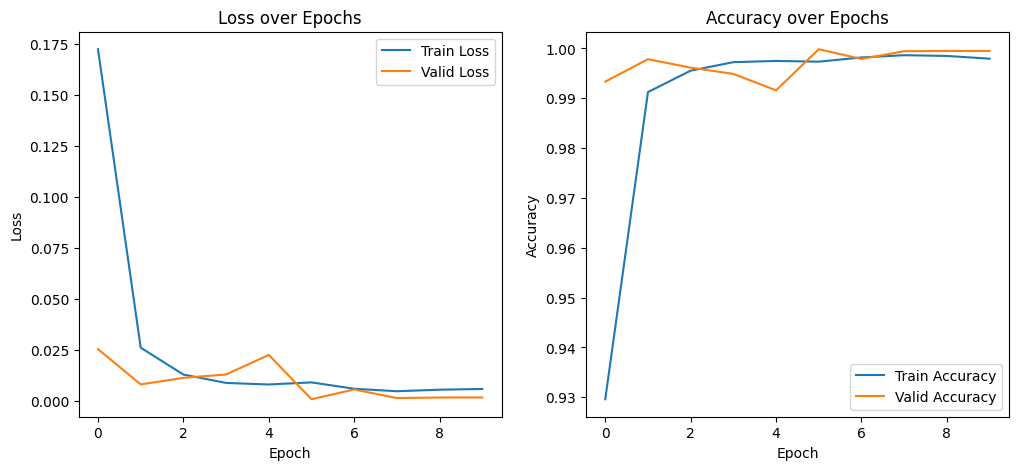

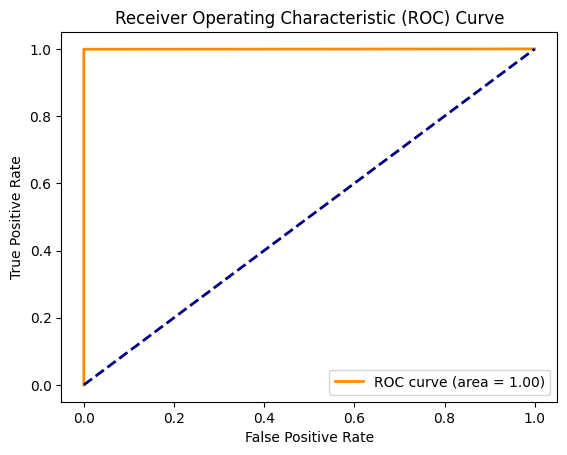

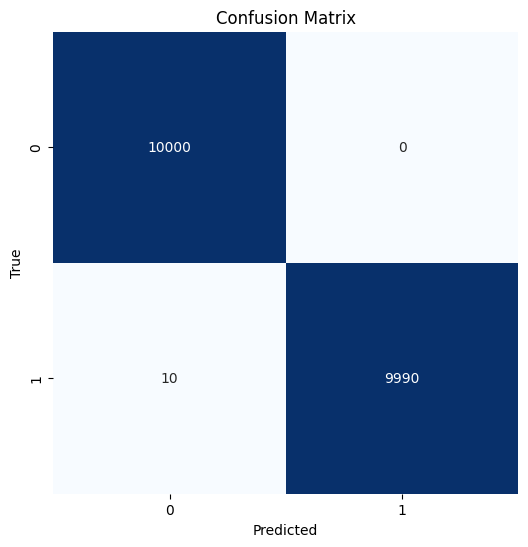

In [ ]:
def plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(valid_accuracies, label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.show()


def plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(valid_accuracies, label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.show()

def plot_roc_curve(all_labels, all_preds):
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Tracer les courbes de loss et d'accuracy
plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies)

# Tracer la courbe ROC-AUC
plot_roc_curve(all_labels, all_preds)

# Afficher la matrice de confusion
plot_confusion_matrix(all_labels, all_preds)

# Testing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Mettre le modèle en mode évaluation
model = model.to(device)


model.eval()

# Initialiser les listes pour stocker les prédictions et les étiquettes
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        # Déplacer les données sur le GPU
        images, labels = images.to(device), labels.to(device)

        # Obtenir les prédictions du modèle
        outputs = model(images)  # Retourne directement les logits
        probs = torch.softmax(outputs, dim=1)  # Appliquer softmax directement sur les logits
        _, preds = torch.max(probs, 1)

        # Stocker les prédictions, les étiquettes et les probabilités
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convertir en arrays numpy et calculer les métriques
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculer et afficher les métriques
accuracy = accuracy_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs[:, 1])
mcc = matthews_corrcoef(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
kappa = cohen_kappa_score(all_labels, all_preds)
logloss = log_loss(all_labels, all_probs)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)

tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

100%|██████████| 625/625 [07:21<00:00,  1.41it/s]

Accuracy: 0.9983
AUC: 1.0000
MCC: 0.9966
F1-score: 0.9983
Specificity: 0.9982
Cohen's Kappa: 0.9966
Log Loss: 0.0082
Recall: 0.9984
Precision: 0.9982


# Wang Dataset

In [ ]:
# Définir les transformations avec data augmentation pour l'entraînement
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Removed p parameter
    transforms.GaussianBlur(kernel_size=3),  # Using GaussianBlur from torchvision
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Définir les transformations pour la validation et le test (sans data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionner les images
    transforms.ToTensor(),  # Convertir en tenseur
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normaliser
])


# Charger les datasets avec les transformations appropriées
train_dataset = ImageFolder(root="/kaggle/input/train-dataset/train_dataset", transform=test_transform)
valid_dataset = ImageFolder(root="/kaggle/input/val-dataset/val_dataset", transform=test_transform)
test_dataset = ImageFolder(root="/kaggle/input/test-progan/progan/person", transform=test_transform)

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Entraînement et validation
train_losses, valid_losses, train_accuracies, valid_accuracies, all_labels, all_preds = train_model(
    model, train_loader, valid_loader, epochs=10, device='cuda'
)
torch.save(model.state_dict(), 'optimizedvit_model.pth')

Epoch 1/10: 100%|██████████| 5626/5626 [45:49<00:00,  2.05it/s]


Epoch 1/10, Train Loss: 0.0238, Train Accuracy: 0.9911, Valid Loss: 0.0106, Valid Accuracy: 0.9960, Valid ROC-AUC: 0.9960


Epoch 2/10: 100%|██████████| 5626/5626 [32:07<00:00,  2.92it/s]


Epoch 2/10, Train Loss: 0.0043, Train Accuracy: 0.9986, Valid Loss: 0.0116, Valid Accuracy: 0.9975, Valid ROC-AUC: 0.9975


Epoch 3/10: 100%|██████████| 5626/5626 [32:15<00:00,  2.91it/s]


Epoch 3/10, Train Loss: 0.0027, Train Accuracy: 0.9991, Valid Loss: 0.0141, Valid Accuracy: 0.9965, Valid ROC-AUC: 0.9965


Epoch 4/10: 100%|██████████| 5626/5626 [32:21<00:00,  2.90it/s]


Epoch 4/10, Train Loss: 0.0021, Train Accuracy: 0.9994, Valid Loss: 0.0228, Valid Accuracy: 0.9955, Valid ROC-AUC: 0.9955


Epoch 5/10: 100%|██████████| 5626/5626 [32:19<00:00,  2.90it/s]


Epoch 5/10, Train Loss: 0.0015, Train Accuracy: 0.9995, Valid Loss: 0.0324, Valid Accuracy: 0.9911, Valid ROC-AUC: 0.9915


Epoch 6/10: 100%|██████████| 5626/5626 [32:31<00:00,  2.88it/s]


Epoch 6/10, Train Loss: 0.0017, Train Accuracy: 0.9995, Valid Loss: 0.0353, Valid Accuracy: 0.9955, Valid ROC-AUC: 0.9955


Epoch 7/10: 100%|██████████| 5626/5626 [32:27<00:00,  2.89it/s]


Epoch 7/10, Train Loss: 0.0014, Train Accuracy: 0.9996, Valid Loss: 0.0137, Valid Accuracy: 0.9970, Valid ROC-AUC: 0.9970


Epoch 8/10: 100%|██████████| 5626/5626 [32:01<00:00,  2.93it/s]


Epoch 8/10, Train Loss: 0.0011, Train Accuracy: 0.9997, Valid Loss: 0.0172, Valid Accuracy: 0.9936, Valid ROC-AUC: 0.9940


Epoch 9/10: 100%|██████████| 5626/5626 [32:07<00:00,  2.92it/s]


Epoch 9/10, Train Loss: 0.0013, Train Accuracy: 0.9997, Valid Loss: 0.0127, Valid Accuracy: 0.9960, Valid ROC-AUC: 0.9960


Epoch 10/10: 100%|██████████| 5626/5626 [32:19<00:00,  2.90it/s]


Epoch 10/10, Train Loss: 0.0008, Train Accuracy: 0.9997, Valid Loss: 0.0293, Valid Accuracy: 0.9950, Valid ROC-AUC: 0.9955


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Mettre le modèle en mode évaluation
model = model.to(device)


model.eval()

# Initialiser les listes pour stocker les prédictions et les étiquettes
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        # Déplacer les données sur le GPU
        images, labels = images.to(device), labels.to(device)

        # Obtenir les prédictions du modèle
        outputs = model(images)  # Retourne directement les logits
        probs = torch.softmax(outputs, dim=1)  # Appliquer softmax directement sur les logits
        _, preds = torch.max(probs, 1)

        # Stocker les prédictions, les étiquettes et les probabilités
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convertir en arrays numpy et calculer les métriques
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculer et afficher les métriques
accuracy = accuracy_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs[:, 1])
mcc = matthews_corrcoef(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
kappa = cohen_kappa_score(all_labels, all_preds)
logloss = log_loss(all_labels, all_probs)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)

tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

100%|██████████| 13/13 [00:09<00:00,  1.36it/s]

Accuracy: 0.9975
AUC: 0.9975
MCC: 0.9950
F1-score: 0.9975
Specificity: 0.9950
Cohen's Kappa: 0.9950
Log Loss: 0.0399
Recall: 1.0000
Precision: 0.9950


# Deepfake Faces Dataset

In [ ]:
import os
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

def get_data():
    return pd.read_csv('/kaggle/input/deepfake-faces/metadata.csv')

meta=get_data()

real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 16293

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        # Construct the image path using os.path.join
        image_path = os.path.join('/kaggle/input/deepfake-faces/faces_224', img[:-4] + '.jpg')

        # Check if the image file exists before attempting to load it
        if os.path.exists(image_path):
            image = cv2.imread(image_path)

            # Check if the image was loaded successfully
            if image is not None:
                images.append(image)
                if(imclass=='FAKE'):
                    labels.append(1)
                else:
                    labels.append(0)
            else:
                print(f"Warning: Could not load image at path: {image_path}")
        else:
            print(f"Warning: Image file does not exist at path: {image_path}")

    return np.array(images),np.array(labels)

X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

In [ ]:

from torch.utils.data import Dataset, DataLoader
# Dataset personnalisé pour les images de deepfake
class DeepfakeDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        # Conversion BGR -> RGB car OpenCV charge en BGR mais PyTorch attend RGB
        self.images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations de données
def get_transforms():
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(90),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Removed p parameter
        transforms.GaussianBlur(kernel_size=3),  # Using GaussianBlur from torchvision
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return transform

# Définir les transformations pour la validation et le test (sans data augmentation)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Redimensionner les images
    transforms.ToTensor(),  # Convertir en tenseur
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normaliser
    ])
# Créer les dataloaders
transform = get_transforms()
train_dataset = DeepfakeDataset(X_train, y_train, transform=transform)
val_dataset = DeepfakeDataset(X_val, y_val, transform=test_transform)
test_dataset = DeepfakeDataset(X_test, y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Entraînement et validation
train_losses, valid_losses, train_accuracies, valid_accuracies, all_labels, all_preds = train_model(
    model, train_loader, val_loader, epochs=10, device='cuda'
)
torch.save(model.state_dict(), 'optimizedvit_model.pth')

Epoch 1/10: 100%|██████████| 570/570 [01:27<00:00,  6.49it/s]


Epoch 1/10, Train Loss: 0.5574, Train Accuracy: 0.7028, Valid Loss: 0.4632, Valid Accuracy: 0.7737, Valid ROC-AUC: 0.7741


Epoch 2/10: 100%|██████████| 570/570 [01:38<00:00,  5.77it/s]


Epoch 2/10, Train Loss: 0.3666, Train Accuracy: 0.8317, Valid Loss: 0.3976, Valid Accuracy: 0.8160, Valid ROC-AUC: 0.8161


Epoch 3/10: 100%|██████████| 570/570 [01:38<00:00,  5.77it/s]


Epoch 3/10, Train Loss: 0.2173, Train Accuracy: 0.9113, Valid Loss: 0.4690, Valid Accuracy: 0.8078, Valid ROC-AUC: 0.8085


Epoch 4/10: 100%|██████████| 570/570 [01:38<00:00,  5.81it/s]


Epoch 4/10, Train Loss: 0.1101, Train Accuracy: 0.9587, Valid Loss: 0.4938, Valid Accuracy: 0.8265, Valid ROC-AUC: 0.8266


Epoch 5/10: 100%|██████████| 570/570 [01:38<00:00,  5.79it/s]


Epoch 5/10, Train Loss: 0.0636, Train Accuracy: 0.9771, Valid Loss: 0.5759, Valid Accuracy: 0.8289, Valid ROC-AUC: 0.8294


Epoch 6/10: 100%|██████████| 570/570 [01:38<00:00,  5.81it/s]


Epoch 6/10, Train Loss: 0.0456, Train Accuracy: 0.9833, Valid Loss: 0.6170, Valid Accuracy: 0.8262, Valid ROC-AUC: 0.8268


Epoch 7/10: 100%|██████████| 570/570 [01:38<00:00,  5.81it/s]


Epoch 7/10, Train Loss: 0.0362, Train Accuracy: 0.9880, Valid Loss: 0.6411, Valid Accuracy: 0.8324, Valid ROC-AUC: 0.8328


Epoch 8/10: 100%|██████████| 570/570 [01:37<00:00,  5.82it/s]


Epoch 8/10, Train Loss: 0.0276, Train Accuracy: 0.9913, Valid Loss: 0.7516, Valid Accuracy: 0.8148, Valid ROC-AUC: 0.8151


Epoch 9/10: 100%|██████████| 570/570 [01:37<00:00,  5.85it/s]


Epoch 9/10, Train Loss: 0.0287, Train Accuracy: 0.9918, Valid Loss: 0.6634, Valid Accuracy: 0.8302, Valid ROC-AUC: 0.8306


Epoch 10/10: 100%|██████████| 570/570 [01:38<00:00,  5.82it/s]


Epoch 10/10, Train Loss: 0.0275, Train Accuracy: 0.9905, Valid Loss: 0.7076, Valid Accuracy: 0.8278, Valid ROC-AUC: 0.8282


In [ ]:
import torch
import numpy as np
from torchmetrics import CohenKappa
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    matthews_corrcoef,
    f1_score,
    confusion_matrix,
    cohen_kappa_score,
    log_loss,
    recall_score,
    precision_score,
)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Mettre le modèle en mode évaluation
model.eval()

# Initialiser les listes pour stocker les prédictions et les étiquettes
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        # Déplacer les données sur le GPU
        images, labels = images.to(device), labels.to(device)

        # Obtenir les prédictions du modèle
        outputs = model(images)  # Retourne directement les logits
        probs = torch.softmax(outputs.logits, dim=1)
  # Appliquer softmax directement sur les logits
        _, preds = torch.max(probs, 1)

        # Stocker les prédictions, les étiquettes et les probabilités
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convertir en arrays numpy et calculer les métriques
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculer et afficher les métriques
accuracy = accuracy_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs[:, 1])
mcc = matthews_corrcoef(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
kappa = cohen_kappa_score(all_labels, all_preds)
logloss = log_loss(all_labels, all_probs)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)

tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

100%|██████████| 204/204 [01:21<00:00,  2.51it/s]

Accuracy: 0.9050
AUC: 0.9693
MCC: 0.8102
F1-score: 0.9041
Specificity: 0.9147
Cohen's Kappa: 0.8101
Log Loss: 0.3719
Recall: 0.8954
Precision: 0.9130


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Mettre le modèle en mode évaluation
model = model.to(device)


model.eval()

# Initialiser les listes pour stocker les prédictions et les étiquettes
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        # Déplacer les données sur le GPU
        images, labels = images.to(device), labels.to(device)

        # Obtenir les prédictions du modèle
        outputs = model(images)  # Retourne directement les logits
        probs = torch.softmax(outputs, dim=1)  # Appliquer softmax directement sur les logits
        _, preds = torch.max(probs, 1)

        # Stocker les prédictions, les étiquettes et les probabilités
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convertir en arrays numpy et calculer les métriques
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculer et afficher les métriques
accuracy = accuracy_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs[:, 1])
mcc = matthews_corrcoef(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
kappa = cohen_kappa_score(all_labels, all_preds)
logloss = log_loss(all_labels, all_probs)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)

tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

100%|██████████| 204/204 [01:19<00:00,  2.56it/s]


Accuracy: 0.8236
AUC: 0.9102
MCC: 0.6472
F1-score: 0.8228
Specificity: 0.8279
Cohen's Kappa: 0.6471
Log Loss: 0.7191
Recall: 0.8193
Precision: 0.8264


# GradCAM

In [ ]:
import torch
import numpy as np
import cv2
from transformers import ViTFeatureExtractor
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

class GradCAMForCustomViT:
    def __init__(self, model):
        self.model = model.eval()
        self.feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
        self.attention_maps = None
        self.attention_gradients = None
        self.classes = ['fake', 'real']

        # Register hooks on both p_l_t and p_s_l in the latent attention
        def get_attention_maps(module, input, output):
            # Calculer et sauvegarder les cartes d'attention
            batch_size, seq_len, _ = input[0].shape
            K = torch.bmm(module.wk.unsqueeze(0).expand(batch_size, -1, -1),
                         input[0].transpose(1, 2))
            Q = torch.bmm(module.wq.unsqueeze(0).expand(batch_size, -1, -1),
                         input[0].transpose(1, 2))

            scale = np.sqrt(module.dim)
            p_l_t = F.softmax(Q / scale, dim=1)
            p_s_l = F.softmax(K / scale, dim=1)

            self.attention_maps = (p_l_t, p_s_l)

        def save_gradients(module, grad_input, grad_output):
            self.attention_gradients = grad_output[0]

        self.model.latent_attention.register_forward_hook(get_attention_maps)
        self.model.latent_attention.register_full_backward_hook(save_gradients)

    def get_prediction(self, logits):
        probs = F.softmax(logits, dim=1)
        prediction = torch.argmax(probs, dim=1)
        confidence = probs[0][prediction].item()
        predicted_class = self.classes[prediction.item()]
        return predicted_class, confidence

    def generate_cam(self, image_path, target_class=None):
        # Charger et prétraiter l'image
        image = Image.open(image_path)
        inputs = self.feature_extractor(images=image, return_tensors="pt")

        # Déplacer sur le même device que le modèle
        device = next(self.model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward pass
        self.model.zero_grad()
        logits = self.model(inputs['pixel_values'])

        # Obtenir la prédiction
        predicted_class, confidence = self.get_prediction(logits)

        if target_class is None:
            target_class = logits.argmax(dim=1)

        # Backward pass
        one_hot = torch.zeros_like(logits)
        one_hot[0, target_class] = 1
        logits.backward(gradient=one_hot)

        # Extraire p_l_t et p_s_l des cartes d'attention sauvegardées
        p_l_t, p_s_l = self.attention_maps

        # Calculer la carte d'attention finale
        # Combiner les deux types d'attention
        attention_weights = torch.bmm(p_l_t.transpose(1, 2), p_s_l)  # [B, S, S]

        # Prendre la moyenne sur les têtes d'attention
        attention_weights = attention_weights.mean(dim=0)  # [S, S]

        # Ne garder que les tokens d'image (enlever le token CLS)
        attention_weights = attention_weights[1:, 1:]  # [196, 196]

        # Reshape en grille 14x14
        cam = attention_weights.mean(dim=1).reshape(14, 14)

        # Convertir en numpy et normaliser
        cam = cam.cpu().detach().numpy()
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)

        # Redimensionner à la taille de l'image
        cam = cv2.resize(cam, (224, 224))

        return cam, predicted_class, confidence

    def visualize(self, image_path, target_class=None, save_path=None, alpha=0.5):
        # Générer la carte d'attention et obtenir la prédiction
        cam, predicted_class, confidence = self.generate_cam(image_path, target_class)

        # Charger l'image originale
        original_image = cv2.imread(image_path)
        original_image = cv2.resize(original_image, (224, 224))
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Créer la heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Superposer la heatmap sur l'image originale
        superimposed = cv2.addWeighted(original_image, 1-alpha, heatmap, alpha, 0)

        # Afficher les résultats
        plt.figure(figsize=(12, 4))

        plt.suptitle(f'Prediction: {predicted_class} (Confidence: {confidence:.2%})',
                    fontsize=14, y=1.05)

        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(original_image)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Attention Map')
        plt.imshow(cam, cmap='jet')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Overlay')
        plt.imshow(superimposed)
        plt.axis('off')

        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.show()

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Total images to process: 10
Processing 52876.jpg...


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


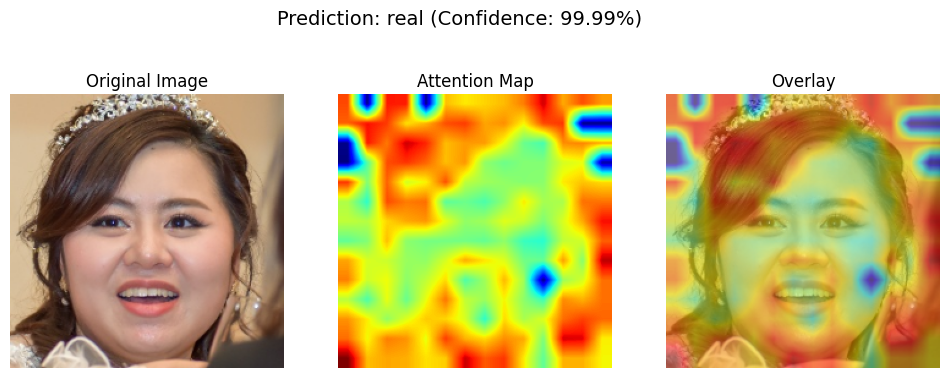

Processing 59454.jpg...


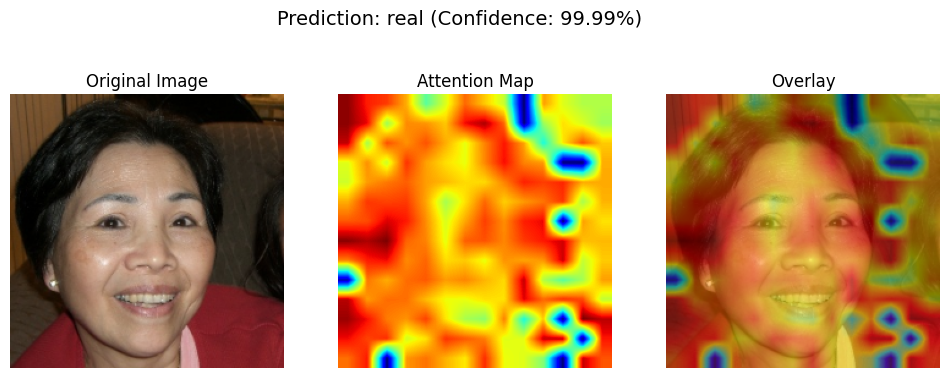

Processing 53932.jpg...


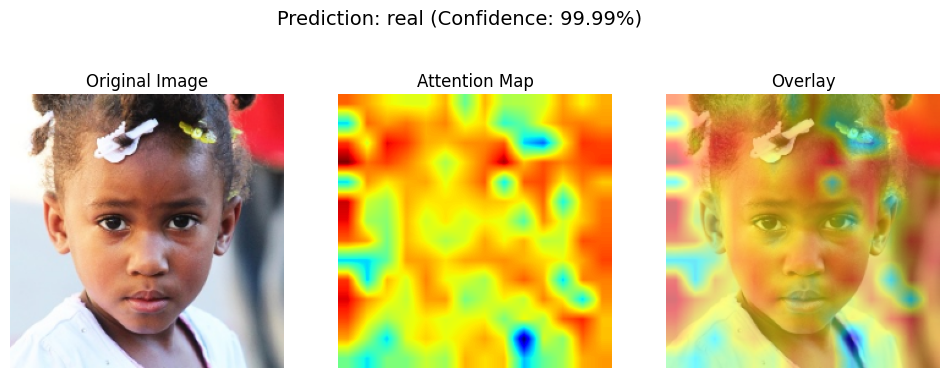

Processing 52203.jpg...


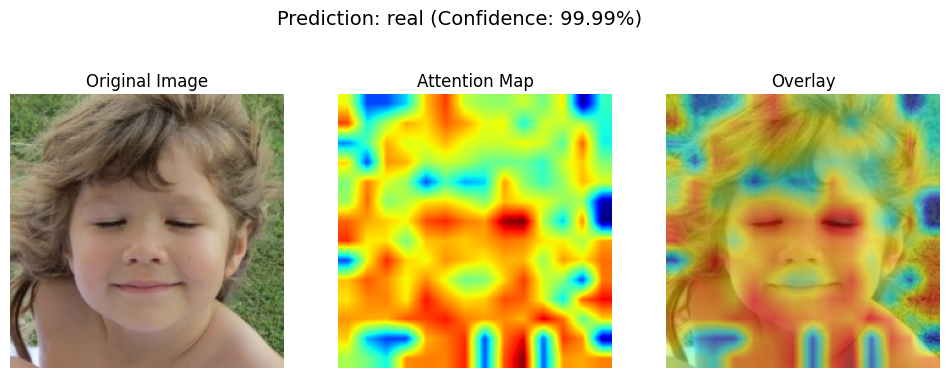

Processing 28578.jpg...


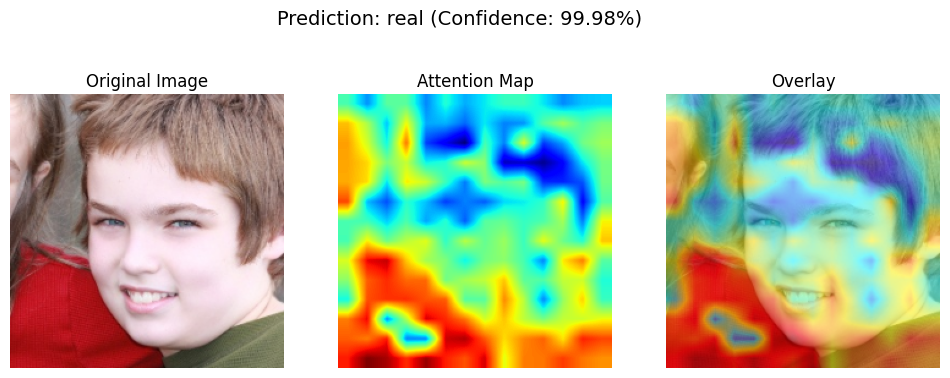

Processing 22288.jpg...


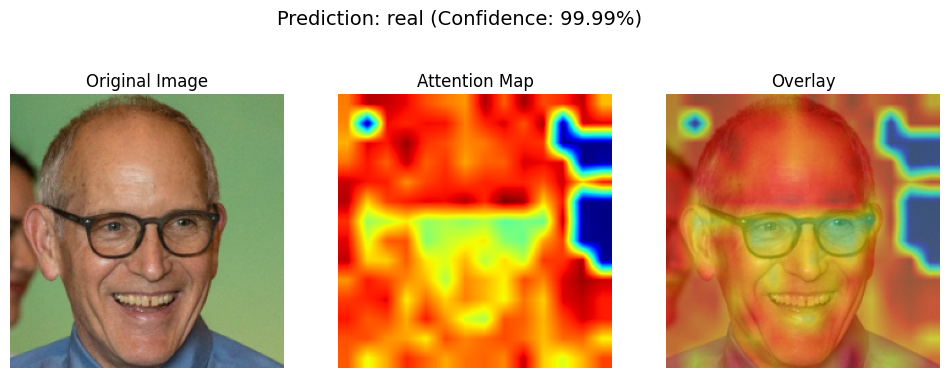

Processing 54415.jpg...


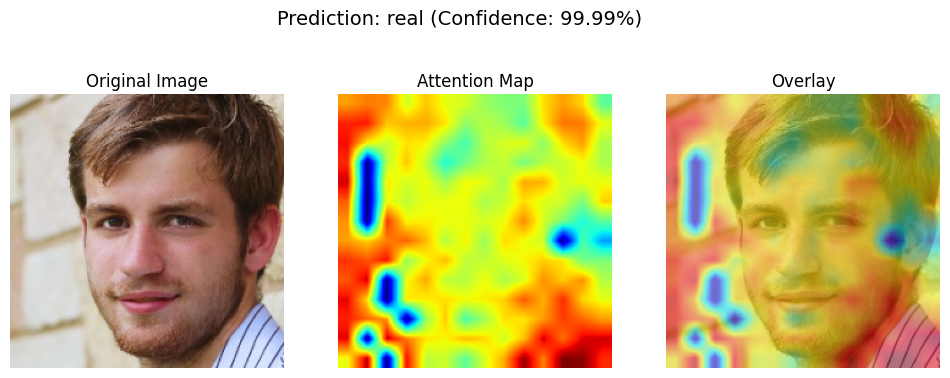

Processing 00767.jpg...


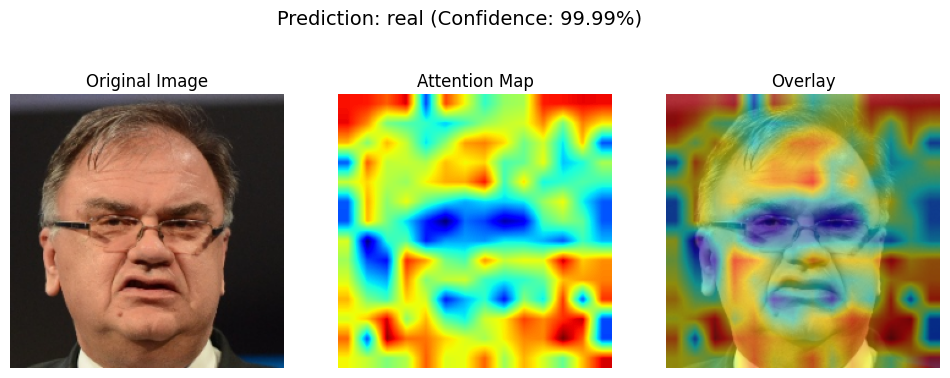

Processing 59221.jpg...


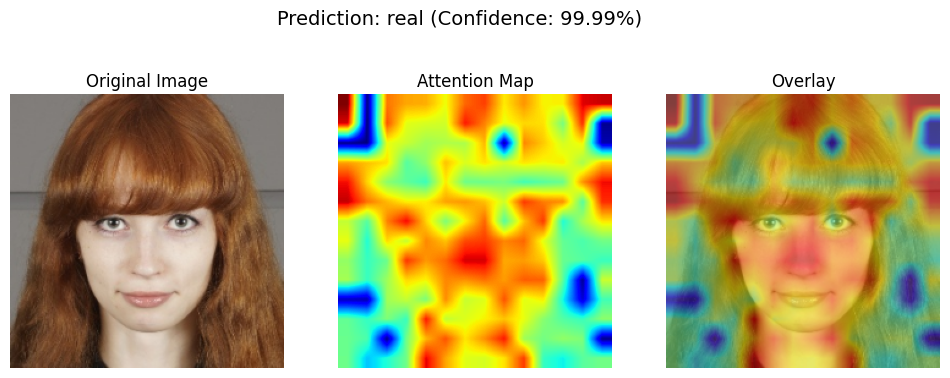

Processing 20529.jpg...


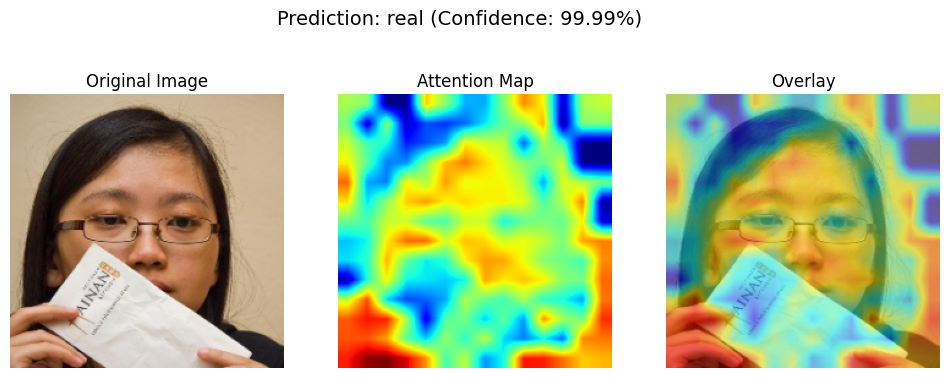

In [ ]:
import os
    # Initialize GradCAM
grad_cam = GradCAMForCustomViT(model)
def apply_gradcam_folder(model, grad_cam, folder_path, save_folder=None, target_class=None, max_images=None):
    """
    model: ton modèle
    grad_cam: ton instance GradCAMForCustomViT
    folder_path: dossier images
    save_folder: où sauvegarder (facultatif)
    target_class: index classe cible (facultatif)
    max_images: nombre max d'images à traiter (facultatif)
    """
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Limiter si demandé
    if max_images is not None:
        image_files = image_files[:max_images]

    print(f"Total images to process: {len(image_files)}")

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        print(f"Processing {img_file}...")

        save_path = None
        if save_folder:
            os.makedirs(save_folder, exist_ok=True)
            save_path = os.path.join(save_folder, f"gradcam_{img_file}")

        grad_cam.visualize(img_path, target_class=target_class, save_path=save_path, alpha=0.5)


apply_gradcam_folder(
    model=model,
    grad_cam=grad_cam,
    folder_path="/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real",
    save_folder="gradcam_results",
    target_class=None,
    max_images=10  # par exemple, traiter seulement 10 images
)


Total images to process: 10
Processing DAOH5G9O0Z.jpg...


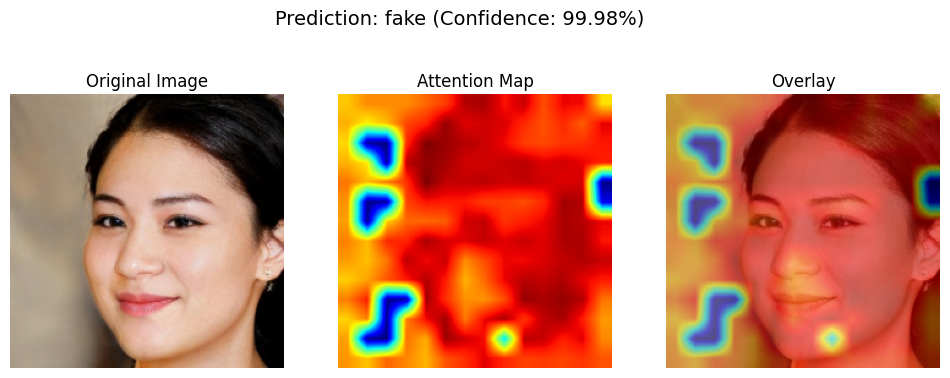

Processing IPZTUVD9OS.jpg...


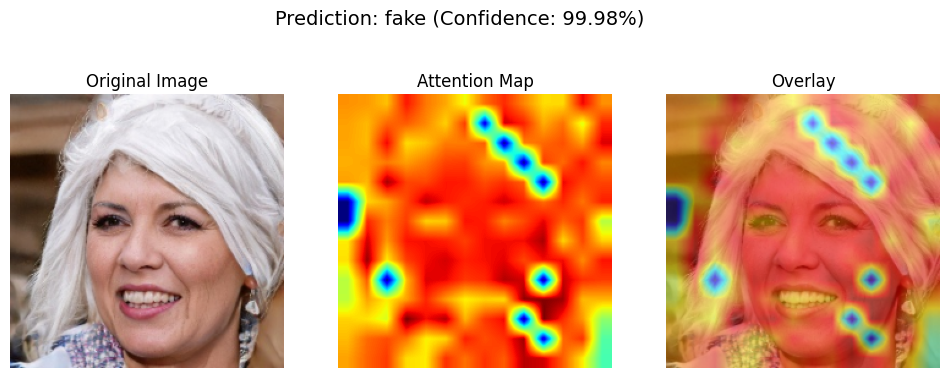

Processing 8L0KA3MXPC.jpg...


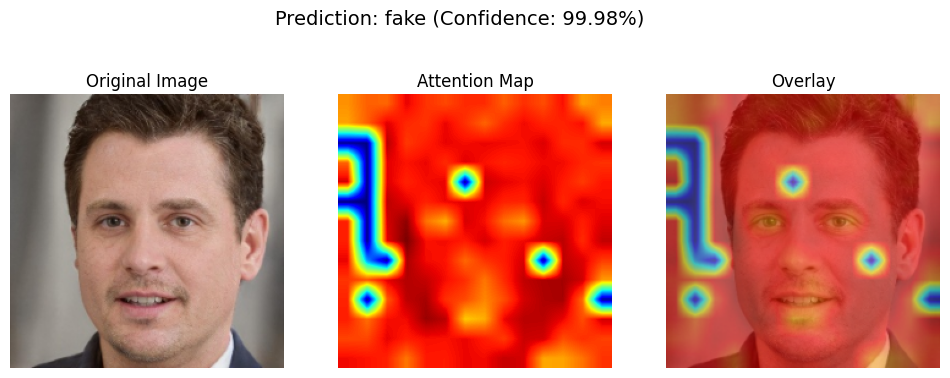

Processing UU38CFFH24.jpg...


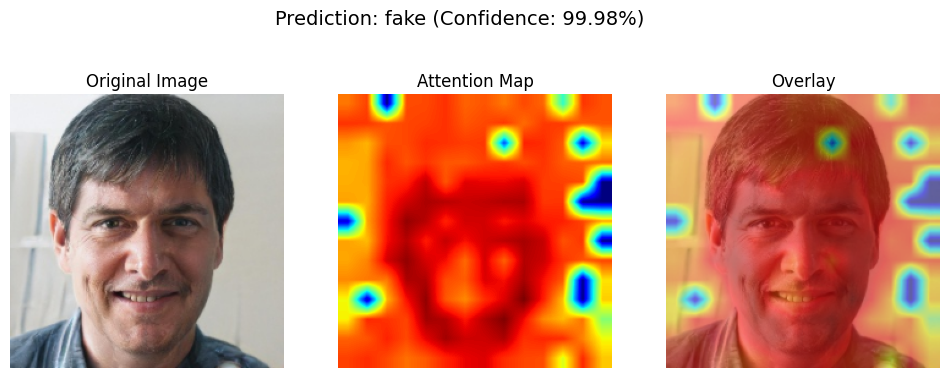

Processing G88GNSJ3YI.jpg...


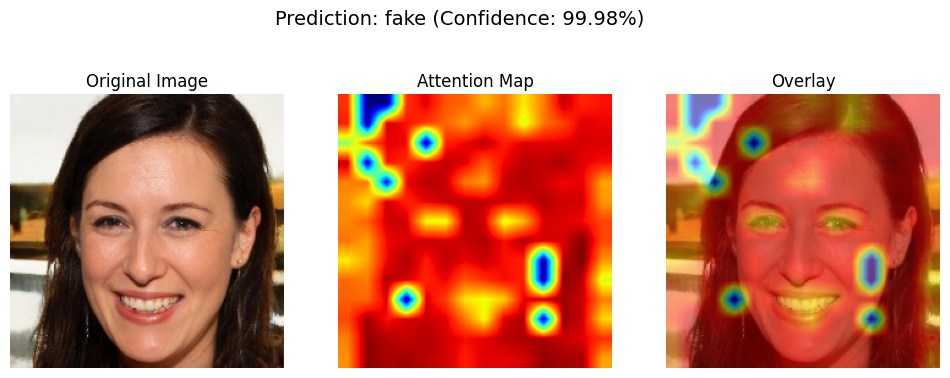

Processing 851IXC4FEH.jpg...


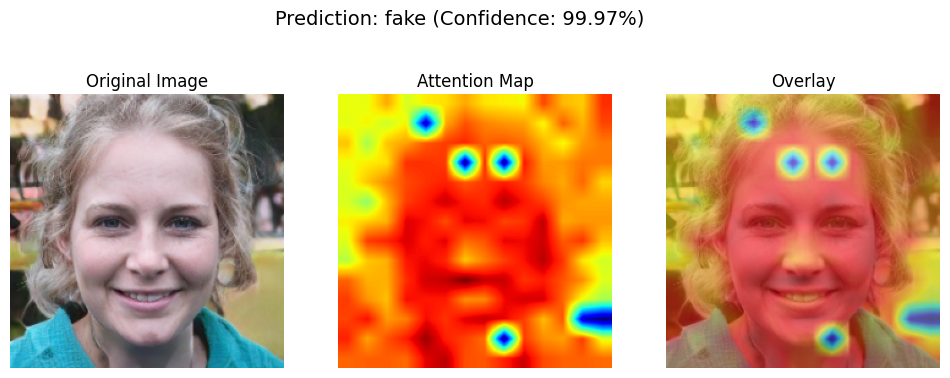

Processing O2MT16VSNV.jpg...


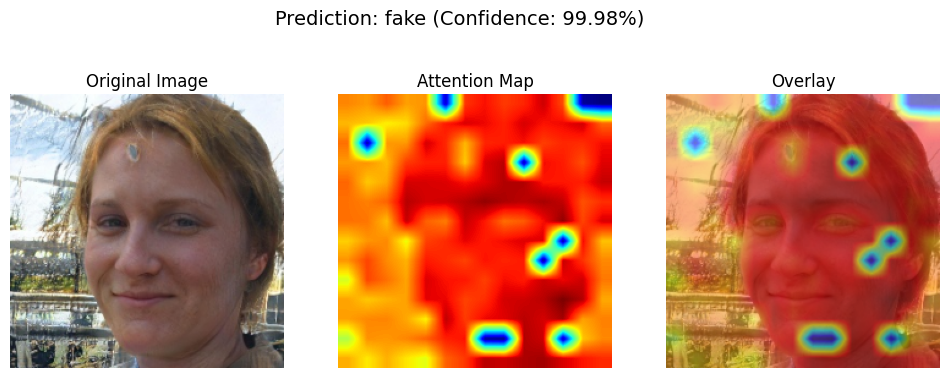

Processing PI2RRDSUIM.jpg...


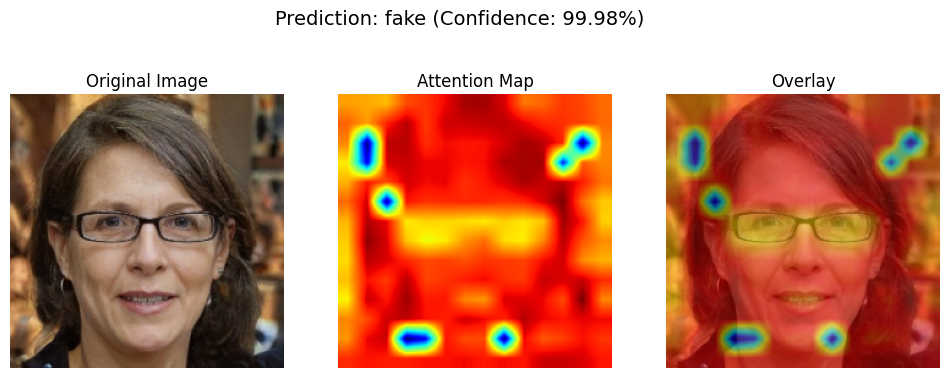

Processing 34JDONPL94.jpg...


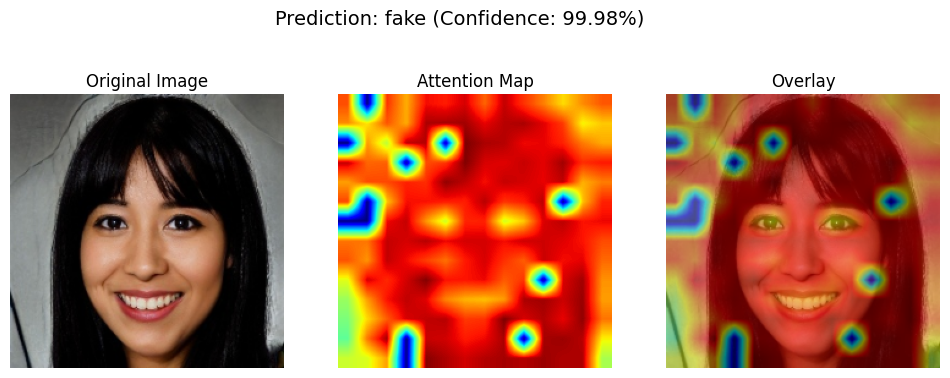

Processing 02NUKFGPSJ.jpg...


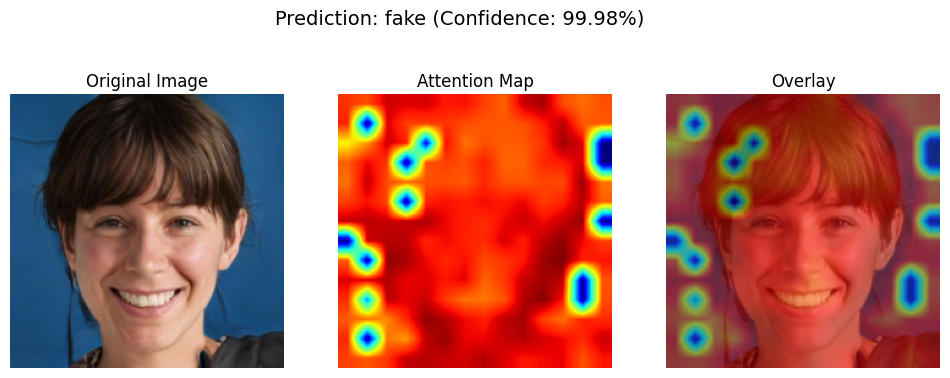

In [ ]:
import os

def apply_gradcam_folder(model, grad_cam, folder_path, save_folder=None, target_class=None, max_images=None):
    """
    model: ton modèle
    grad_cam: ton instance GradCAMForCustomViT
    folder_path: dossier images
    save_folder: où sauvegarder (facultatif)
    target_class: index classe cible (facultatif)
    max_images: nombre max d'images à traiter (facultatif)
    """
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Limiter si demandé
    if max_images is not None:
        image_files = image_files[:max_images]

    print(f"Total images to process: {len(image_files)}")

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        print(f"Processing {img_file}...")

        save_path = None
        if save_folder:
            os.makedirs(save_folder, exist_ok=True)
            save_path = os.path.join(save_folder, f"gradcam_{img_file}")

        grad_cam.visualize(img_path, target_class=target_class, save_path=save_path, alpha=0.5)


apply_gradcam_folder(
    model=model,
    grad_cam=grad_cam,
    folder_path="/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake",
    save_folder="gradcam_results",
    target_class=None,
    max_images=10  # par exemple, traiter seulement 10 images
)


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np

def create_gradcam_grid(model, grad_cam, folder_path, max_images=3, save_path="gradcam_grid.png"):
    """
    model: ton modèle CustomViT
    grad_cam: instance GradCAMForCustomViT
    folder_path: dossier des images originales
    max_images: nombre d'images à traiter
    """
    image_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])[:max_images]

    rows = len(image_files)
    fig, axes = plt.subplots(rows, 3, figsize=(9, rows * 2.5))  # 3 colonnes : original, heatmap, overlay

    for idx, img_file in enumerate(image_files):
        print(f"Processing {img_file}...")
        img_path = os.path.join(folder_path, img_file)

        # === Apply GradCAM directly ===
        cam, predicted_class, confidence = grad_cam.generate_cam(img_path)

        # Load original image
        original = cv2.imread(img_path)
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        original_resized = cv2.resize(original, (224, 224))

        # Create heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Overlay heatmap
        overlay = cv2.addWeighted(original_resized, 0.5, heatmap, 0.5, 0)

        # === Plot ===
        axes[idx, 0].imshow(original_resized)
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(cam, cmap='jet')
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(overlay)
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


Processing 00001.jpg...
Processing 00004.jpg...
Processing 00007.jpg...


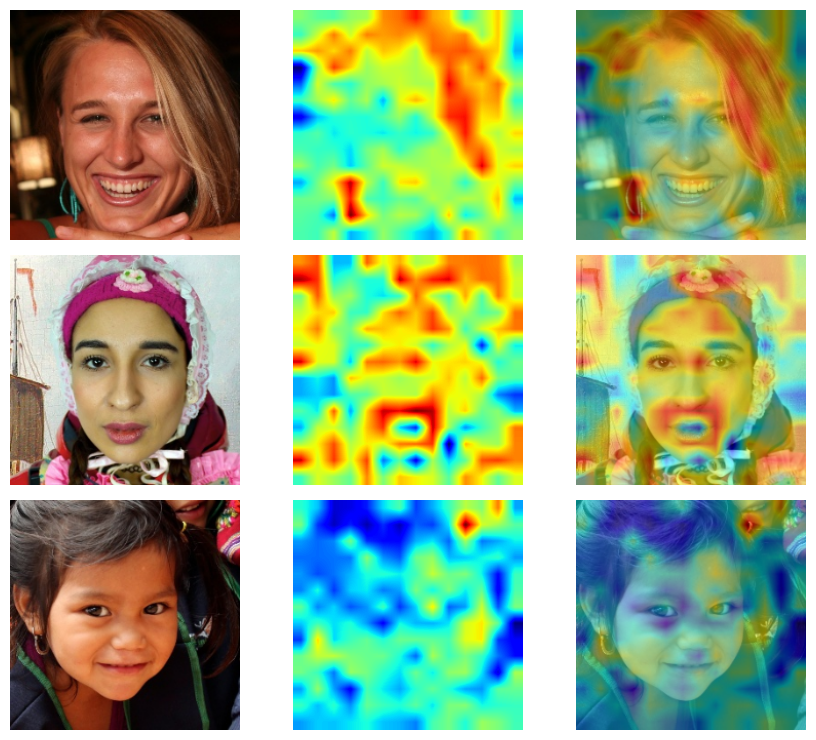

In [ ]:
create_gradcam_grid(
    model=model,
    grad_cam=grad_cam,
    folder_path="/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real",
    max_images=3,
    save_path="gradcam_real.png"
)
